In [1]:
import pandas as pd
import itertools
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [2]:
stk_data = yf.download("RELIANCE.NS", start="2013-06-01", end="2022-02-11")
stk_data

C:\Users\admin\AppData\Local\Temp\ipykernel_19096\4010520275.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stk_data = yf.download("RELIANCE.NS", start="2013-06-01", end="2022-02-11")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2013-06-03,167.620468,171.332833,167.056686,170.981802,14165128
2013-06-04,165.982346,170.152124,165.758971,168.194884,14752690
2013-06-05,170.620148,171.109458,166.046155,166.046155,12748842
2013-06-06,168.492722,171.024366,167.663032,170.194677,17113393
2013-06-07,166.705673,170.620152,166.152542,168.960745,9420701
...,...,...,...,...,...
2022-02-04,1065.005981,1072.840675,1060.346346,1069.437239,11061241
2022-02-07,1058.519165,1076.655277,1052.991451,1069.894201,10714467


In [42]:
# performing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
MS = MinMaxScaler()
data = MS.fit_transform(stk_data)
print("Len:",data.shape)

Len: (2144, 5)


In [44]:
data = pd.DataFrame(data,columns = ["Open","High","Low","Close","Volume"],index=stk_data.index)

In [46]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2013-06-03,0.001514,0.002707,0.004227,0.004541,0.099277
2013-06-04,0.000000,0.001622,0.003019,0.001977,0.103395
2013-06-05,0.004286,0.002502,0.003286,0.000000,0.089351
2013-06-06,0.002320,0.002424,0.004791,0.003817,0.119940
2013-06-07,0.000669,0.002052,0.003385,0.002682,0.066025
...,...,...,...,...,...
2022-02-04,0.830885,0.830910,0.835519,0.831146,0.077523
2022-02-07,0.824890,0.834414,0.828675,0.831566,0.075093
2022-02-08,0.841335,0.835757,0.830801,0.826796,0.084529


In [48]:
# Convert back to DataFrame for indexing
scaled_column = pd.DataFrame(stk_data, index=stk_data.index, columns=stk_data.columns)

In [50]:
scaled_column

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2013-06-03,167.620468,171.332833,167.056686,170.981802,14165128
2013-06-04,165.982346,170.152124,165.758971,168.194884,14752690
2013-06-05,170.620148,171.109458,166.046155,166.046155,12748842
2013-06-06,168.492722,171.024366,167.663032,170.194677,17113393
2013-06-07,166.705673,170.620152,166.152542,168.960745,9420701
...,...,...,...,...,...
2022-02-04,1065.005981,1072.840675,1060.346346,1069.437239,11061241
2022-02-07,1058.519165,1076.655277,1052.991451,1069.894201,10714467


In [52]:
# Split train and test set

training_size = round(len(scaled_column) * 0.80)
print (training_size)
X_train = scaled_column[:training_size]
X_test = scaled_column[training_size:]
print ("X_train length:", X_train.shape)
print ("X_test length:", X_test.shape)
Y_train = scaled_column[:training_size]
Y_test = scaled_column[training_size:]
print ("Y_train length:", Y_train.shape)
print ("Y_test length:", Y_test.shape)

1715
X_train length: (1715, 5)
X_test length: (429, 5)
Y_train length: (1715, 5)
Y_test length: (429, 5)


In [54]:
#Define model combinations
combinations = [['Close', 'High'],['Close', 'High', 'Open'],['Close', 'High', 'Open', 'Low']]

# Result Storage
performance={"Model":[],"RMSE":[],"MaPe":[],"Lag":[],"Test":[]}


# Define exogenous variable
exog_var = ['Volume']  # make sure this exists in your dataset

In [56]:

test_obs = 28  # forecast steps

# Loop through each feature combination
for cols in combinations:
    dataset = data[cols]
    exog = data[exog_var]

    # Split data
    train = dataset.iloc[:-test_obs]
    test = dataset.iloc[-test_obs:]

    train_exog = exog[:-test_obs]
    test_exog = exog[-test_obs:]

# Find best (p, q) using AIC 
    #best_aic = float('inf')  # Start with a very high AIC so anything will be better
    #best_order = (0, 0)
    #best_model = None

    model = VARMAX(train, exog=train_exog, order=(1, 0), enforce_stationarity=True) # enforce_stationarity=True - ensures model stability 
    results = model.fit(disp=False)
    #if results.aic < best_aic:
        #best_aic = results.aic
        #print(best_aic)
        #best_order = (p, q)
        #best_model = results

    print('AIC: ', results.aic)
    print('BIC: ', results.bic)

    # Forecast
    pred = results.forecast(steps=test_obs, exog=test_exog)
    pred.index = test.index
    pred_df = pd.DataFrame(pred, columns=cols)

    #pred_df.to_csv("VARMAXforecasted_{}.csv".format(test_obs))

    # Metrics
    rmse = round(mean_squared_error(test, pred_df, squared=False), 4)
    mape = round(mean_absolute_percentage_error(test, pred_df), 6)

    # Save performance
    performance["Model"].append(cols)
    performance["RMSE"].append(rmse)
    performance["MaPe"].append(mape)
    performance["Lag"].append("AR=1, MA=0")
    performance["Test"].append(test_obs)

perf_df = pd.DataFrame(performance)



C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC:  -27418.502936680336
BIC:  -27356.272825957574


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\s

AIC:  -45593.327214560486
BIC:  -45474.52427590794


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\s

AIC:  -59966.63280655059
BIC:  -59774.285191589326


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
perf_df

,Model,RMSE,MaPe,Lag,Test
0,"[Close, High]",0.1801,0.194554,"AR=1, MA=0",28
1,"[Close, High, Open]",0.2364,0.254962,"AR=1, MA=0",28
2,"[Close, High, Open, Low]",0.2303,0.248364,"AR=1, MA=0",28


In [58]:
pred

,Close,High,Open,Low
Date,,,,
2022-01-03,0.828800,0.831543,0.829259,0.831552
2022-01-04,0.812066,0.816142,0.812530,0.813526
2022-01-05,0.796080,0.800435,0.796484,0.797163
2022-01-06,0.780681,0.785491,0.781256,0.781461
2022-01-07,0.765889,0.770445,0.766325,0.766701
2022-01-10,0.751185,0.754949,0.751335,0.752356
2022-01-11,0.736835,0.741624,0.737538,0.737576
2022-01-12,0.723482,0.728075,0.724015,0.724183
2022-01-13,0.710204,0.714188,0.710515,0.711172


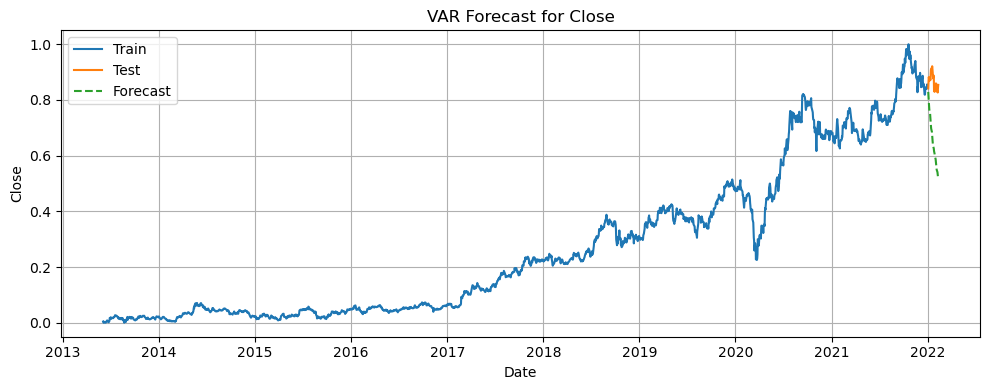

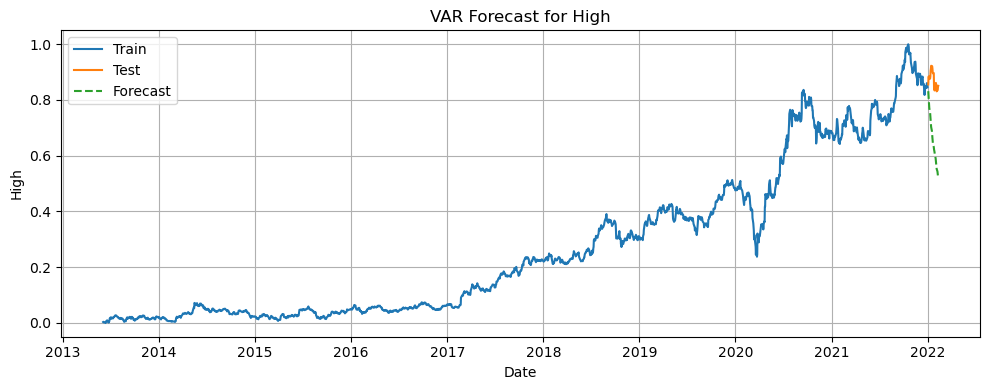

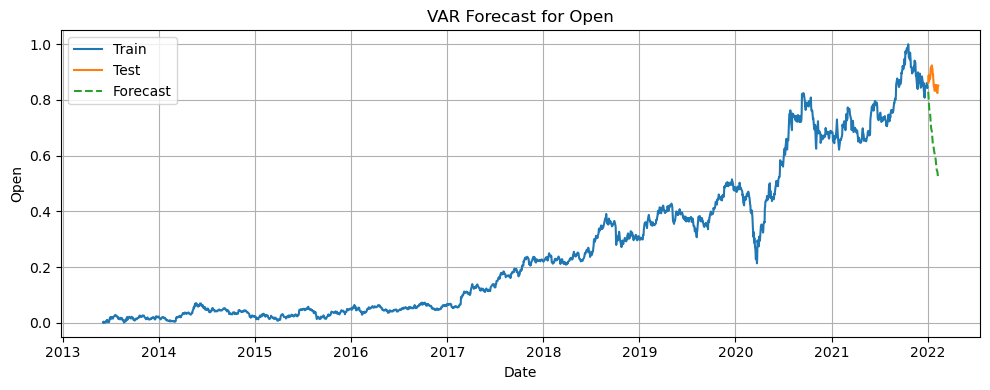

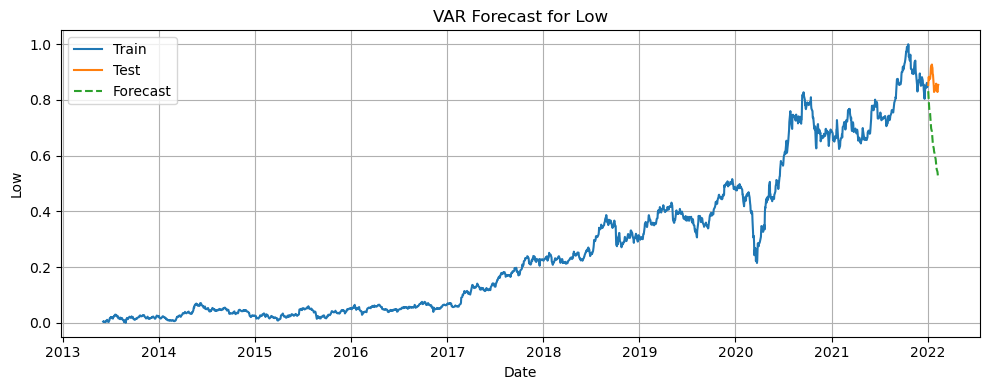

In [76]:
  # ---- Plotting ----
for col in cols:
    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train[col], label='Train')
    plt.plot(test.index, test[col], label='Test')
    plt.plot(pred.index, pred_df[col], label='Forecast', linestyle='--')
    plt.title(f"VAR Forecast for {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
